In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators
from src.hops import runge_kutta
from src.hops import hops_rk_simple
from src.hops import hops_trotter_simple
from src.homps import homps_model
from src.mps import mps
from src.mps import mps_runge_kutta

In [3]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 0.5
T = 1/beta
gamma = 0.25
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

In [4]:
N_terms = 1

In [5]:
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)

In [6]:
N_steps = 1000
N_trunc = 40 # starting from N_trunc = 39 this gets numerically instable ...
chimax = 10
epsilon = 0
N_krylov = 5

Computing N_trunc = 35
Computing N_trunc = 38
Computing N_trunc = 39
Computing N_trunc = 40


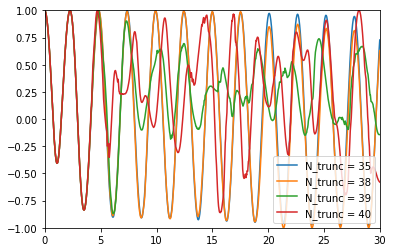

In [11]:
for N_trunc in [35, 38, 39, 40]:
    print("Computing N_trunc =", N_trunc)
    hierarchy = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=epsilon, N_krylov=N_krylov, method="RK4")
    psis = hierarchy.compute_realizations(1)
    sigma_zs = compute_exp_val_linear(psis, sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="N_trunc = "+str(N_trunc))

plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

We will look closer at the case N_trunc = 40

In [146]:
N_trunc = 35
chi_max = 10
eps = 1.e-15

In [147]:
duration = 60
N_steps = 2000

In [148]:
# Helper function extracting the physical state (copied from homps.py)
def extract_physical_state(psi, model):
    contr = psi.Bs[-1][:, 0, 0] # vL
    for i in range(model.N_bath-1, 0, -1):
        print(i)
        contr = np.tensordot(psi.Bs[i][:, 0, :], contr, ([1], [0])) # vL [vR], [vL] -> vL
    result = np.tensordot(psi.Bs[0][0, :, :], contr, ([1], [0])) # i [vR], [vL] -> i
    return result * psi.norm

In [149]:
# Setup HOPS
hops = hops_rk_simple.HOPS_Simple_RK4(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False)
psi = np.zeros(2*N_trunc, dtype=complex)
psi[0] = 1.
psis = np.empty((1, N_steps, 2), dtype=complex)
psis[0, 0, :] = psi[0:2].copy()

# Setup HOMPS
model = homps_model.HOMPSModel(g, w, h, L, N_trunc)
model.compute_update_mpo()
psi_mps = mps.MPS.init_HOMPS_MPS(np.array([1, 0], dtype=complex), 1, N_trunc)
psis_mps = np.empty((1, N_steps, 2), dtype=complex)
psis_mps[0, 0, :] = extract_physical_state(psi_mps, model)

psis[0, 0, :] = psi[0:2].copy()

for i in range(N_steps-1):
    
    # integrate psi
    psi = runge_kutta.integrate_RK4(psi, 2*i, hops.dt, hops.f_linear)
    psi_physical = psi[0:2]
    psis[0, i+1, :] = psi_physical
    
    # integrate psi_mps
    psi_mps = mps_runge_kutta.integrate_MPS_RK4(psi_mps, hops.dt, model.update_mpo, chi_max, eps)
    psi_mps_physical = extract_physical_state(psi_mps, model)
    psis_mps[0, i+1, :] = psi_mps_physical
    
    # Compare and print diff
    print("diff:", np.linalg.norm(np.abs(psi_physical - psi_mps_physical))/np.linalg.norm(np.abs(psi_physical)))

diff: 1.44445006612677e-15
diff: 1.5625548367305345e-15
diff: 2.9199303668146424e-15
diff: 3.0627475922262826e-15
diff: 2.643659164027404e-15
diff: 3.1335902259356143e-15
diff: 2.495767131519818e-15
diff: 2.301845896380429e-15
diff: 1.6149755481205824e-15
diff: 1.9368034087722354e-15
diff: 2.6778299725098895e-15
diff: 2.46272959130106e-15
diff: 2.61104823914635e-15
diff: 2.5983992112736872e-15
diff: 2.3193280558059836e-15
diff: 1.7855055338148577e-15
diff: 2.191682951950277e-15
diff: 2.5079034715215843e-15
diff: 2.710366806102167e-15
diff: 2.6193433527038265e-15
diff: 2.45731348538072e-15
diff: 2.8296604578359804e-15
diff: 2.0899925839641706e-15
diff: 2.2746708201534825e-15
diff: 2.2121953437971583e-15
diff: 2.022273117579269e-15
diff: 1.95632968199277e-15
diff: 1.6321100256559481e-15
diff: 1.127913899201651e-15
diff: 2.352779720948509e-15
diff: 3.282566661094478e-15
diff: 3.800438570421105e-15
diff: 3.5814863697188575e-15
diff: 3.805009997221517e-15
diff: 3.694480162320188e-15
diff: 4

diff: 0.0016442872163627959
diff: 0.0015819681808891628
diff: 0.0015945088740745767
diff: 0.0016126837249985496
diff: 0.0016115957190301683
diff: 0.0015628861709170616
diff: 0.0015716123229317486
diff: 0.0015598396086469483
diff: 0.001562052369282177
diff: 0.0015524599716366032
diff: 0.0015630888541799553
diff: 0.001583748334288301
diff: 0.0015592887807762666
diff: 0.0015684024968297314
diff: 0.0015763378523030046
diff: 0.0015986507666370946
diff: 0.0016187251389466258
diff: 0.0015845808666435385
diff: 0.001581758151754118
diff: 0.001588574441332321
diff: 0.001602555690037638
diff: 0.0016099232801938953
diff: 0.0015951747229171031
diff: 0.0016252280903833822
diff: 0.0016808310859647898
diff: 0.0016569322226715536
diff: 0.0016476963476578898
diff: 0.0016652593742012508
diff: 0.0016976105600480672
diff: 0.0017873454741707236
diff: 0.001836697317304862
diff: 0.001876038107809837
diff: 0.0018214213336877776
diff: 0.0018023550513634212
diff: 0.0018438207506213792
diff: 0.0019617855399447015

diff: 0.007717481154329233
diff: 0.007746220253393346
diff: 0.007619143722614112
diff: 0.007608918985435875
diff: 0.007475598612301693
diff: 0.00744274349189363
diff: 0.007405052425090442
diff: 0.007349819870895872
diff: 0.007370306647488106
diff: 0.007287922133951455
diff: 0.007203382870055412
diff: 0.007114246387525149
diff: 0.007105799016073808
diff: 0.007169143263424355
diff: 0.007138713297155682
diff: 0.00712797189280786
diff: 0.007093975890059885
diff: 0.0069523903065685
diff: 0.006895128471354882
diff: 0.006959713607306702
diff: 0.006864768525273817
diff: 0.006816255322825711
diff: 0.006861122791272128
diff: 0.006838373841775961
diff: 0.00676766300573944
diff: 0.006698158387069625
diff: 0.006650402329661892
diff: 0.006722553412283637
diff: 0.006597073980768091
diff: 0.006616497857759691
diff: 0.006650517198916752
diff: 0.006631504605845413
diff: 0.006589245400418251
diff: 0.006766580910611916
diff: 0.006681673900090614
diff: 0.006583198207042208
diff: 0.0066816128860149515
diff:

diff: 0.008687578394173735
diff: 0.008713043809346246
diff: 0.008741649017802203
diff: 0.008735371336188775
diff: 0.0087647843769096
diff: 0.008774181851179208
diff: 0.008799647581593054
diff: 0.008826655397523905
diff: 0.008859992064017002
diff: 0.008921908985698081
diff: 0.008856208613804059
diff: 0.008711902713377252
diff: 0.008789996906144938
diff: 0.008723862600900844
diff: 0.008577295433411203
diff: 0.008741770595560767
diff: 0.008852508720184858
diff: 0.008972516922237113
diff: 0.00895695823116455
diff: 0.008800329881679515
diff: 0.008898549552134503
diff: 0.008809122557416485
diff: 0.008898956229782828
diff: 0.008835812986262532
diff: 0.008751761979718387
diff: 0.008731005063084572
diff: 0.00863979748598298
diff: 0.00853453546229771
diff: 0.008244716086593402
diff: 0.008085383988718324
diff: 0.008098602484958996
diff: 0.008103730130108436
diff: 0.007889094808504787
diff: 0.008003835794838723
diff: 0.007770471644918042
diff: 0.007730773562419711
diff: 0.007469075848585662
diff: 

diff: 0.008178525349121245
diff: 0.0081616479703162
diff: 0.008122750580119164
diff: 0.008153655424594241
diff: 0.008189255323517034
diff: 0.008148783168843704
diff: 0.00817683387254243
diff: 0.008238131500302752
diff: 0.008263872388576779
diff: 0.00818443000372904
diff: 0.008099363297645384
diff: 0.008262663388538535
diff: 0.008167178970647896
diff: 0.008076569523305136
diff: 0.007926015256150847
diff: 0.00797498481415193
diff: 0.007830380237025
diff: 0.007748690217967427
diff: 0.007812998355362297
diff: 0.007780835753392449
diff: 0.007882553000345219
diff: 0.008029667024433277
diff: 0.007956205840202414
diff: 0.00817586460071398
diff: 0.008109226829466978
diff: 0.008214776402308992
diff: 0.008163146226270231
diff: 0.00806267905915171
diff: 0.008087151750927555
diff: 0.008119963816207314
diff: 0.008025136478633479
diff: 0.008046145982772372
diff: 0.00800165275960844
diff: 0.007967676427697776
diff: 0.008025731164675287
diff: 0.008000960575129492
diff: 0.008006990048286084
diff: 0.0079

diff: 0.007572985955947818
diff: 0.007591679331085024
diff: 0.007518716624731059
diff: 0.007477086770818938
diff: 0.007345387282069705
diff: 0.007458882509986528
diff: 0.007461261416436374
diff: 0.007453044378249662
diff: 0.007530056736883695
diff: 0.0075601113292063935
diff: 0.007657549355387708
diff: 0.007674150987376207
diff: 0.007955942271503168
diff: 0.007933934572527897
diff: 0.007759121273002284
diff: 0.007728543192682259
diff: 0.007921125837713611
diff: 0.00790610456672029
diff: 0.007783597996458706
diff: 0.007700610699341797
diff: 0.007846398206648382
diff: 0.007921690542151538
diff: 0.007885478038856773
diff: 0.007866215104465972
diff: 0.007896475482089844
diff: 0.008018441681590322
diff: 0.00813223518714106
diff: 0.00808407481185575
diff: 0.008098266140811735
diff: 0.008087919882999365
diff: 0.0080940242080948
diff: 0.00811643546457931
diff: 0.008121252170936623
diff: 0.008145555889619623
diff: 0.008099502425144194
diff: 0.008087592162188809
diff: 0.00815188725884383
diff: 0

In [150]:
sigma_zs = compute_exp_val_linear(psis, sigma_z)
sigma_zs_mps = compute_exp_val_linear(psis_mps, sigma_z)

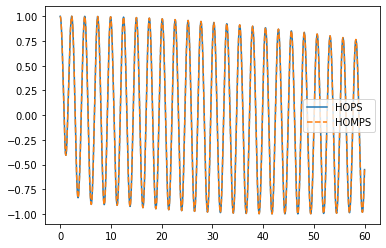

In [151]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="HOPS")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_mps, "--", label="HOMPS")
plt.legend()
plt.show()